In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import torch
import random

# Generic Folder dataset

In [2]:
class FolderDataset(torch.utils.data.Dataset):
    
    def __init__(self, root_folder, file_extensions, x_tfms=None):
        root_folder = pathlib.Path(root_folder)

        def dir_conditions(folder: pathlib.PosixPath) -> bool:
            is_folder  = folder.is_dir()
            not_empty  = any(folder.iterdir()) if is_folder else False
            not_hidden = not folder.name.startswith('.')
            return is_folder and not_empty and not_hidden
        
        def file_conditions(file: pathlib.PosixPath) -> bool:
            is_file    = file.is_file()
            good_file  = file.name.endswith(file_extensions) # str or tuple of strings
            not_hidden = not file.name.startswith('.')
            return is_file and good_file and not_hidden

        #               __element__  ____________________________loop____________________________   
        self.classes = [folder.name  for folder in root_folder.iterdir() if dir_conditions(folder)]
        self.classes.sort()
        
        self.class2num = {cls_name: i for i,cls_name in enumerate(self.classes)}

        #                 ______________xy_element______________    
        self.samples = [ (str(file), self.class2num[class_folder.name]) 
        #                _________________________1st loop_________________________
                         for class_folder in root_folder.iterdir() if dir_conditions(class_folder)
        #                _________________________2nd loop_________________________
                         for group_folder in class_folder.iterdir() if dir_conditions(group_folder)
        #                ______________________3rd loop______________________
                         for file in group_folder.iterdir() if file_conditions(file) ]

        self.x_tfms = x_tfms
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        x, y = self.samples[idx]
        if self.x_tfms: x = self.x_tfms(x)
        return x, torch.tensor(y)
    
    def getlabels(self):
        return list(map(lambda sample: sample[1], train_ds.samples))

# Read and transform images


### OPTION A: Pillow + Torchvision

In [3]:
from PIL import Image
from torchvision import transforms

torchvision_tfms = transforms.Compose([Image.open,
                                       transforms.Resize((128,128)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
                                       #transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])

### OPTION B: OpenCV + Albumentations

In [4]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_img_tfms = A.Compose([
    #A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def albumentations_tfms(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))

    return albumentations_img_tfms(image=img)["image"]

### OPTION C: Kornia?

### Create image dataset

In [5]:
train_ds = FolderDataset(root_folder     = "./mask face train",
                         file_extensions = (".jpg"),
                         x_tfms          = torchvision_tfms)

valid_ds = FolderDataset(root_folder     = "./mask face test",
                         file_extensions = (".jpg"),
                         x_tfms          = torchvision_tfms)

In [6]:
train_ds[0][0].shape

torch.Size([3, 128, 128])

In [7]:
train_ds.class2num

{'mask': 0, 'no mask': 1}

In [8]:
valid_ds.class2num

{'mask': 0, 'no mask': 1}

# Dataloader

In [26]:
class BalanceClassSampler(torch.utils.data.Sampler):
    """
    Allows you to create stratified sample on unbalanced classes.
    Inspired from Catalyst's BalanceClassSampler:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/data/sampler.html#BalanceClassSampler

    Args:
        labels: list of class label for each elem in the dataset
        mode: Strategy to balance classes. Must be one of [downsampling, upsampling]
    """

    def __init__(self, labels:list[int], mode:str = "upsampling"):

        labels = np.array(labels)
        self.unique_labels = set(labels)

        ########## STEP 1:
        # Compute the final_num_samples_per_label
        # An Integer
        num_samples_per_label = {label: (labels == label).sum() for label in self.unique_labels}

        if   mode == "upsampling":   self.final_num_samples_per_label = max(num_samples_per_label.values())
        elif mode == "downsampling": self.final_num_samples_per_label = min(num_samples_per_label.values())
        else:                        raise Exception("mode should be: \"downsampling\" or \"upsampling\"")

        ########## STEP 2:
        # Compute actual indices of every label.
        # A Diccionary of lists
        self.indices_per_label = {label: np.arange(len(labels))[labels==label].tolist() for label in self.unique_labels}


    def __iter__(self): #-> Iterator[int]:

        indices = []
        for label in self.unique_labels:

            label_indices = self.indices_per_label[label]

            repeat_all_elementes  = self.final_num_samples_per_label // len(label_indices)
            pick_random_elementes = self.final_num_samples_per_label %  len(label_indices)

            indices += label_indices * repeat_all_elementes # repeat the list several times
            indices += random.sample(label_indices, k=pick_random_elementes)  # pick random idxs without repetition

        assert len(indices) == self.__len__()
        np.random.shuffle(indices) # Inplace shuffle the list

        return iter(indices)
    

    def __len__(self) -> int:
        return self.final_num_samples_per_label * len(self.unique_labels)

In [10]:
train_dl = torch.utils.data.DataLoader(dataset    = train_ds,
                                       batch_size = 64,
                                       sampler    = BalanceClassSampler(labels = train_ds.getlabels(),
                                                                        mode   = "upsampling"))

valid_dl = torch.utils.data.DataLoader(dataset    = valid_ds,
                                       batch_size = 64,
                                       shuffle    = False)

In [11]:
batch_x, batch_y = next(iter(train_dl))

batch_x.shape, batch_y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

# <center> MODEL
- https://fastai.github.io/timmdocs/
- https://walkwithfastai.com/vision.external.timm
- https://www.kaggle.com/tanlikesmath/seti-et-signal-detection-a-simple-cnn-starter
- https://arxiv.org/pdf/2103.07579.pdf

In [4]:
import timm
print(timm.__version__)

0.4.9


In [3]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_prune

In [12]:
from torchvision import models

model = models.resnet18(pretrained=True)
#model

In [13]:
#for parameter in model.parameters():
#    print(parameter.requires_grad)

### Replace last layer

In [14]:
#model.fc = torch.nn.Linear(512, 1) # torch.nn.Sigmoid() + torch.nn.BCELoss() or torch.nn.BCEWithLogitsLoss
model.fc = torch.nn.Linear(512, 2)  # torch.nn.Softmax() + torch.nn.NLLLoss() or torch.nn.CrossEntropyLoss

loss =  torch.nn.CrossEntropyLoss()
"""
torch.nn.Sequential(
    torch.nn.Linear(512, 1),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)
""";

### Test model on 1 sample

In [15]:
batch_p = model(batch_x)

print("batch_x:", batch_x.shape)
print("batch_p:", batch_p.shape)
print("batch_y:", batch_y.shape)

batch_x: torch.Size([64, 3, 128, 128])
batch_p: torch.Size([64, 2])
batch_y: torch.Size([64])


### Test loss

In [16]:
loss(batch_p, batch_y)

tensor(0.3515, grad_fn=<NllLossBackward>)

# <center> TRAIN

In [17]:
# Using Fast.ai: 2.3.1
from fastai.learner           import Learner
from fastai.data.core         import DataLoaders
from fastai.metrics           import *
from fastai.callback.all      import * # For lr_find() and fit_one_cycle()
from fastai.callback.core     import Callback
from fastai.callback.progress import ProgressCallback, ShowGraphCallback
from fastai.callback.training import GradientClip
from fastai.callback.rnn      import ModelResetter, RNNCallback, RNNRegularizer
from fastai.callback.tracker  import EarlyStoppingCallback

In [18]:
learn = Learner(dls       = DataLoaders(train_dl, valid_dl),
                model     = model, 
                loss_func = loss,
                metrics   = [accuracy, BalancedAccuracy(), F1Score(), Precision(), Recall(), RocAucBinary()], 
                cbs       = [ShowGraphCallback])
#learn.show_training_loop()

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=9.120108734350652e-05)

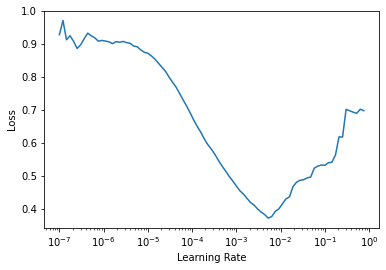

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,time
0,0.005581,0.012178,0.996716,0.966797,0.998306,0.997931,0.998682,0.997692,02:46


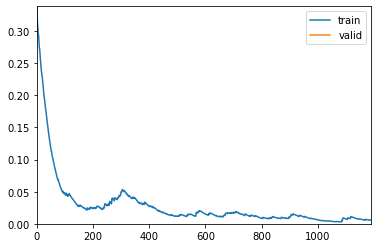

In [19]:
# Shuffle
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,time
0,0.075002,0.031628,0.992459,0.989426,0.996096,0.999558,0.992658,0.998887,00:30


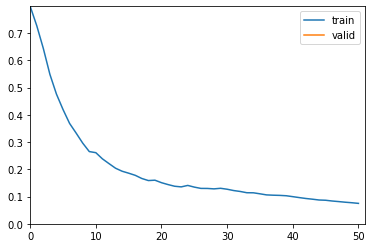

In [19]:
# Downsampling
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,time
0,0.000306,0.011734,0.997507,0.986301,0.998713,0.999183,0.998243,0.997581,05:30


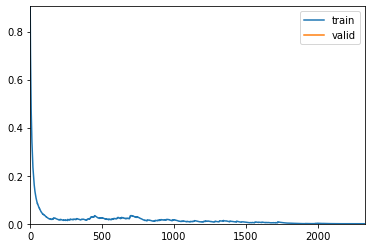

In [19]:
# Upsampling
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,time
0,0.075292,0.012454,0.997811,0.984548,0.998870,0.999058,0.998682,0.997976,00:27


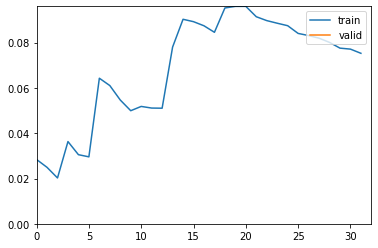

In [27]:
# 1000 imgs per class
learn.fit_one_cycle(1, 1e-3)

|              |  train_loss |  valid_loss |  accuracy   |balanced_acc |  f1_score   | precision   |  recall     |  roc_auc    | time    |
|--------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|---------|
| shuffle	   |  0.005581   |  0.012178   |  0.996716   |  0.966797   |  0.998306   |  0.997931   |**0.998682** |  0.997692   |  02:46  |
| downsampling |  0.075002   |  0.031628   |  0.992459   |**0.989426** |  0.996096   |**0.999558** |  0.992658   |**0.998887** |  00:30  |
| upsampling   |  0.000306   |**0.011734** |  0.997507   |  0.986301   |  0.998713   |  0.999183   |  0.998243   |  0.997581   |  05:30  |
| 1000perclass |  0.075292   |  0.012454   |**0.997811** |  0.984548   |**0.998870** |  0.999058   |**0.998682** |  0.997976   |  00:27  |